<a href="https://colab.research.google.com/github/acollin19/comp551/blob/Angele/A2/assignment2_group_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2

## Process:

### Task 1: Data Processing  


1. IMDB Reviews
2. 20 news groups: a multi-class labelled textual dataset


### Task 2: Implement Logistic and Multiclass classifiers

1. Logistic Regression
2. Multiclass Regression
3. Comparisons using ROC curve


### Task 3: Running Experiments



1.    Most positive/negative Z-scores
2.   Implement:  
    * Binary classification on the IMDB Reviews

  *   Multi-class classification on the 20 news group dataset

3. Binary classification AUROC on IMDB data
  *   Logistic Regression 
  *   KNN

4. Multiclass classification accuracy

5. Compare Accuracy of Models (Plot)







In [110]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_svmlight_file
from scipy.sparse import csr_matrix
import scipy.sparse as sp


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# Multiclass Regression and ROC curve comparisons
from sklearn import model_selection
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression as sk_LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from nltk import word_tokenize, download
from nltk.corpus import stopwords


In [121]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz
!ls aclImdb
!ls aclImdb/test
!ls aclImdb/train


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  12.3M      0  0:00:06  0:00:06 --:--:-- 17.5M
imdbEr.txt  imdb.vocab	README	test  train
labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


In [157]:
# IMDB dataset preprocession
IMDB_X_train, IMDB_y_train= load_svmlight_file('aclImdb/train/labeledBow.feat')
IMDB_X_test, IMDB_y_test = load_svmlight_file('aclImdb/test/labeledBow.feat') 


# Task 1 : Data processing



## Task 1.1 : IMDB

 - X contain features based on the words in the movie reviews
 - y contain labels for whether the review score

In [158]:
# 1st element in tuple represents the file its in, 2nd element represents the index of word it represents in vocab, float represents frequency
# want to remove the words that appear in less than 1% of all documents # only appear in 250 documents
# want to remove the words that appear in more than 50% of all documents # appear in 12500 documents
sign = sum(IMDB_X_train.sign()) # 1 if the word appears in the text 0 if not
good = ((sign < 12500) - (sign < 250))
indices = sp.find(good)

IMDB_X_train = IMDB_X_train[:,indices[1]]
IMDB_X_test = IMDB_X_test[:,indices[1]]
IMDB_X_train.todense()

print(indices[1])
print(IMDB_X_train.shape[0])



[  21   23   27 ... 1958 1967 1980]
25000


/usr/local/lib/python3.7/dist-packages/scipy/sparse/compressed.py:291: SparseEfficiencyWarning: Comparing a sparse matrix with a scalar greater than zero using < is inefficient, try using >= instead.
  warn(bad_scalar_msg, SparseEfficiencyWarning)


## Z-Score Function

In [159]:
from sklearn.utils.extmath import sparse
# Z - Score
def zscore(X,y):

  N = X.shape[0]
  std = (IMDB_y_train- y.mean()) / y.std()
  z = np. abs(sp.csr_matrix.dot(sp.csr_matrix.transpose(X), std))

  return z

df = pd.DataFrame(IMDB_X_train.toarray())
df.insert(loc=0, column="A", value=IMDB_y_train)
IMDB_X_train = sp.csr_matrix(df.values)
IMDB_X_train.todense()
IMDB_arr = IMDB_X_train.toarray()

zscores = zscore(IMDB_X_train,IMDB_y_train)

highestzindex = np.argsort(zscores)[-200:][::-1] # top 200 highest z scores
lowestzindex = np.argsort(zscores)[:200][::1] # worst 200 highest z scores
zindex = np.concatenate((highestzindex, lowestzindex))

# # get correct indexed feature set
new_IMDB_X_train = IMDB_X_train[:,zindex].toarray()
new_IMDB_X_test = IMDB_X_test[:,zindex].toarray()

# # get correct indexed word list
data = open('aclImdb/imdb.vocab')
vocab = data.read().split('\n')

word_list = [vocab[i]for i in indices[1]]
word_list = [word_list[i] for i in zindex]



In [137]:
# Loading 20 news group dataset
categories=['rec.sport.hockey','sci.electronics','talk.politics.guns','sci.space']
twenty_train = fetch_20newsgroups(subset='train', categories=categories, remove=(['headers', 'footers', 'quotes']), shuffle=True, random_state=42)

'''
Cleaning: 
- filter out rare words, stopwords, and words that are not relevant to any of the 4 class labels.
- MI to select the top M ∈ [10, 100] feature words per class and take the union of all top feature words to train your multiclass model.

'''

download('punkt') #tokenizer, run once
download('stopwords') #stopwords dictionary, run once

# Tokenize, remove stopwords
stop_words = stopwords.words('english')

def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    # Restricts string to alphabetic characters only
    doc = [word for word in doc if word.isalpha()] 
    return doc

# text and ground truth labels
texts, y = twenty_train.data, twenty_train.target

corpus = [preprocess(text) for text in texts]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Task 1.2 : Twenty Train

Text preprocessing, tokenizing and filtering of stopwords are all included in the CountVectorizer function


In [ ]:
# Turn the text content into feature vectors
count_vect = CountVectorizer() 
X_train_counts = count_vect.fit_transform(twenty_train.data) # builds a dict of features and transforms docs to feature vectors
X_train_counts.shape

# Occurences to frequences : TF_IDF

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [ ]:
X = twenty_train.data # Test content

# Turn the text content into feature vectors
count_vect = CountVectorizer() 
X_train_counts = count_vect.fit_transform(twenty_train.data) # builds a dict of features and transforms docs to feature vectors
X_train_counts.shape

# Occurences to frequences : TF_IDF

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X = X_train_tfidf
X.todense()
twenty_train_arr = X.toarray()

y_cat = twenty_train.target
# convert array of class indices to one-hot encoded array
y = np.zeros((y_cat.size, y_cat.max() + 1))
y[np.arange(y_cat.size), y_cat] = 1

#print(zscore(twenty_train_arr))

# Task 2 : Implementing Classes

## Task 2.1 : Logistic Regression Class

In [160]:
# Logistic function
z = np.linspace(-5,5,100)
logistic = lambda z: 1./ (1 + np.exp(-z))

# From class Logistic Regression collab
class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad
        
    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        g = np.inf 
        t = 0
        # the code snippet below is for gradient descent
        while np.linalg.norm(g) > self.epsilon and t < self.max_iters:
            g = self.gradient(x, y)
            self.w = self.w - self.learning_rate * g 
            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

 

### Evaluation using Logistic Regression


In [163]:
# Applying Logistic Regression on the IMDB data

model = LogisticRegression(verbose=True, add_bias=False, max_iters=1e3,learning_rate=.3,epsilon=1e-4)
fit = model.fit(new_IMDB_X_train,IMDB_y_train)

y_train_pred = fit.predict(new_IMDB_X_train)
y_test_pred = fit.predict(new_IMDB_X_test)

# Threshold probabilities
y_train_pred = (y_train_pred > 0.5).astype(int)
y_test_pred = (y_test_pred > 0.5).astype(int)

# Accuracy = correctly classified / total classified
acc_train = sum(y_train_pred==IMDB_y_train)/len(IMDB_y_train)
acc_test = sum(y_test_pred==IMDB_y_test)/len(IMDB_y_test)
print(f"train accuracy: {acc_train:.3f}; test accuracy: {acc_test:.3f}")

# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(IMDB_y_test,y_test_pred)

# Gradient
gradient = model.gradient(new_IMDB_X_train, IMDB_y_train) 
gradient

terminated after 1000 iterations, with norm of the gradient equal to 42.51171188835378
the weight found: [1.09639257e+04 5.84688510e+02 2.54310996e+02 1.77795216e+03
 6.45762198e+02 5.20358772e+02 8.16358506e+02 5.56851816e+02
 1.01987488e+03 9.05044932e+02 4.16083020e+01 8.63735832e+02
 8.56740312e+02 4.41650130e+02 1.69965503e+03 1.08501841e+03
 4.36310184e+02 9.71410806e+02 8.10772800e+02 9.99420912e+02
 5.72478930e+02 3.73910646e+02 2.71754592e+02 2.74778658e+02
 5.93410422e+02 1.60945692e+02 4.07053728e+02 5.70635364e+02
 5.85528912e+02 9.67324602e+02 2.19439884e+02 3.45621948e+02
 6.98542866e+02 1.26771859e+03 3.55798524e+02 2.83179540e+01
 3.58450482e+02 2.02767240e+01 3.76512498e+02 4.31778456e+02
 1.03133628e+02 1.64820414e+02 3.53978220e+01 5.46247194e+02
 1.91883120e+02 1.19484773e+03 4.02821040e+01 8.05296480e+02
 1.37085918e+02 5.31364686e+02 5.00988480e+01 1.15674048e+02
 3.34527780e+01 2.84642868e+02 8.16740280e+01 2.26232424e+02
 5.20097262e+02 5.84753100e+01 1.14290690

array([-3.654368e+01, -1.948640e+00, -8.475200e-01, -5.925920e+00,
       -2.152360e+00, -1.734280e+00, -2.720840e+00, -1.855920e+00,
       -3.399160e+00, -3.016440e+00, -1.386400e-01, -2.878760e+00,
       -2.855520e+00, -1.472040e+00, -5.664920e+00, -3.616360e+00,
       -1.454240e+00, -3.237640e+00, -2.702240e+00, -3.331000e+00,
       -1.908080e+00, -1.246200e+00, -9.057200e-01, -9.158000e-01,
       -1.977840e+00, -5.364000e-01, -1.356720e+00, -1.901880e+00,
       -1.951520e+00, -3.224080e+00, -7.313600e-01, -1.151920e+00,
       -2.328240e+00, -4.225280e+00, -1.185840e+00, -9.436000e-02,
       -1.194680e+00, -6.756000e-02, -1.254880e+00, -1.439080e+00,
       -3.437200e-01, -5.493600e-01, -1.179600e-01, -1.820640e+00,
       -6.395200e-01, -3.982400e+00, -1.342400e-01, -2.684040e+00,
       -4.569200e-01, -1.771000e+00, -1.669600e-01, -3.855200e-01,
       -1.114800e-01, -9.487200e-01, -2.722000e-01, -7.540400e-01,
       -1.733480e+00, -1.948800e-01, -3.809280e+00, -5.279600e

In [167]:
from sklearn.model_selection import cross_val_score, cross_val_predict
# Cross Validation Scores
clf_lr = sk_LogisticRegression()
scores = cross_val_score(clf_lr, new_IMDB_X_train, IMDB_y_train, cv=10, n_jobs=4)
scores

array([0.8164, 0.8064, 0.8132, 0.818 , 0.794 , 0.82  , 0.7936, 0.808 ,
       0.7936, 0.8048])

## Task 2.2 : Multiclass Regression Class

In [ ]:
# From class Multiclass Regression collab
class Multinomial_logistic:
    def __init__(self, nFeatures, nClasses):
        self.W = np.random.rand(nFeatures, nClasses)

    def predict(self, X):
        y_pred = np.exp(np.matmul(X, self.W))
        return y_pred / y_pred.sum(axis=1).reshape(X.shape[0], 1)

    def grad(self, X, y):
        return np.matmul(X.transpose(), self.predict(X) - y)

    def ce(self, X, y):
        return -np.sum(y * np.log(self.predict(X)))

    # modify it to add stopping criteria (what can you think of?)
    def fit(self, X, y, X_valid=None, y_valid=None, lr=0.005, niter=100):
        losses_train = np.zeros(niter)
        losses_valid = np.zeros(niter)
        for i in range(niter):
            self.W = self.W - lr * self.grad(X, y)
            loss_train = self.ce(X, y)
            losses_train[i] = loss_train
            if X_valid is not None and y_valid is not None:
                loss_valid = self.ce(X_valid, y_valid)
                losses_valid[i] = loss_valid
                print(f"iter {i}: {loss_train:.3f}; {loss_valid:.3f}")
            else:
                print(f"iter {i}: {loss_train:.3f}")
        return losses_train, losses_valid

    def check_grad(self, X, y):
        N, C = y.shape
        D = X.shape[1]

        diff = np.zeros((D, C))

        W = self.W.copy()

        for i in range(D):
            for j in range(C):
                epsilon = np.zeros((D, C))
                epsilon[i, j] = np.random.rand() * 1e-4

                self.W = self.W + epsilon
                J1 = self.ce(X, y)
                self.W = W

                self.W = self.W - epsilon
                J2 = self.ce(X, y)
                self.W = W

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = self.grad(X, y)[i, j]

                diff[i, j] = np.square(derived_grad - numeric_grad).sum() / \
                             np.square(derived_grad + numeric_grad).sum()

        # print(diff)
        return diff.sum()

    def evaluate(self, y, y_pred):
      accuracy = sum(y_pred.argmax(axis=1) == y.argmax(axis=1))
      accuracy = accuracy / y.shape[0]

      return accuracy

### Evaluation using Multiclass Regression

In [ ]:
# Applying Multiclass Regression on the 4-class prediction from the 20-news-group data

# Split the data into training, validation, and testing
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size = 0.33, random_state=1, shuffle=True)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(
    X_train, y_train, test_size = 0.5, random_state=1, shuffle=True)

#Create model object
D = X.shape[1]
C = y.shape[1]

mlr = Multinomial_logistic(D, C)

# check grad
print(mlr.check_grad(X_train, y_train))



## Task 2.3 : Method comparison using ROC curve

In [103]:
models = [KNeighborsClassifier(),
          DecisionTreeClassifier(),
          sk_LogisticRegression()]

perf = {}

# our implementation is slow you may try sklearn version
logitreg = sk_LogisticRegression()
fit = logitreg.fit(new_IMDB_X_train, IMDB_y_train)
y_test_prob = fit.predict(new_IMDB_X_test)
fpr, tpr, _ = roc_curve(IMDB_y_test, y_test_prob)
auroc = roc_auc_score(IMDB_y_test, y_test_prob)
perf["LogisticRegression (ours)"] = {'fpr':fpr, 'tpr':tpr, 'auroc':auroc}

for model in models:
    fit = model.fit(new_IMDB_X_train, IMDB_y_train)
    y_test_prob = fit.predict_proba(new_IMDB_X_test)[:,1]
    fpr, tpr, _ = roc_curve(IMDB_y_test, y_test_prob)
    auroc = roc_auc_score(IMDB_y_test, y_test_prob)
    if type(model).__name__ == "LogisticRegression":
        perf["LogisticRegression (sklearn)"] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}
    else:
        perf[type(model).__name__] = {'fpr':fpr,'tpr':tpr,'auroc':auroc}


plt.clf()
i = 0
for model_name, model_perf in perf.items():
    plt.plot(model_perf['fpr'], model_perf['tpr'],label=model_name)
    plt.text(0.4, i+0.1, model_name + ': AUC = '+ str(round(model_perf['auroc'],2)))
    i += 0.1

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title('ROC in predicting Titanic survivor')
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="upper left")
plt.show()
# plt.savefig("roc_curve.png", bbox_inches='tight', dpi=300)
# plt.close()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


ValueError: ignored

# Task 3 : Running Experiments

## Task 3.1 : Z-Scores
Report top 10 features with most positive/negative z-scores on the IMDB data using simple linear regression on the movie rating scores.  

QUESTION TO ANSWER: Do they make sense for calling a movie good and bad, respectively?


ANSWER: The top features with the most positive z-scores do partially make sense as it includes words like 'talents', 'naturally' which are generally used with a positive connotation. 
However, the top features with the most negative don't make sense in terms of calling a movie bad as it includes words such as 'who', 'he' which dont reveal any information as to if a movie is good or bad.




In [144]:
posindexesZ = np.argsort(zindex)[-10:][::-1] # highest-lowest
negindexesZ = np.argsort(zindex)[:10][::1] # lowest-highest

pos = [word_list[i] for i in posindexesZ]
neg = [word_list[i] for i in negindexesZ]

print(pos)
print(zscores[np.argsort(zscores)[-10:][::-1]])
print(neg)
print(zscores[np.argsort(zscores)[:10][::1]])


['received', 'discover', 'noticed', 'naturally', 'talents', 'concerned', 'empty', 'witty', 'hits', 'mixed']
[86660.19703991  6723.9998858   5727.76839835  4812.51525205
  3854.64022019  3589.98336753  3306.88369965  2937.47021926
  2800.26686171  2558.4542105 ]
['he', 'his', '!', 'by', 'an', 'who', 'they', 'from', 'so', 'like']
[0.01938606 0.11033901 0.20391138 0.38087843 0.44247534 0.55575687
 0.74857896 0.75157918 0.75452171 0.83523927]


## Extra Experiemnts: Linear Regression for predicting ratings in the IMDB data

-1.9338009241607796


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


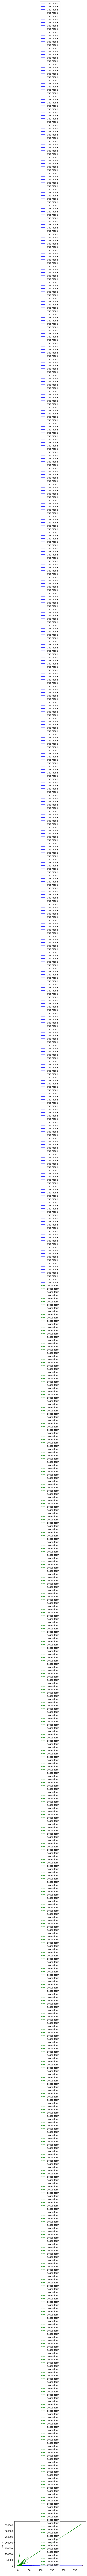

In [146]:
from sklearn.linear_model import LinearRegression
LinR = LinearRegression()
  
LinR.fit(new_IMDB_X_train, IMDB_y_train)
print(LinR.score(new_IMDB_X_test, IMDB_y_test))

true_w = -4
plt.clf()
plt.plot(new_IMDB_X_train, IMDB_y_train, '.')
w_closedform = model.w
plt.plot(new_IMDB_X_train, true_w*new_IMDB_X_train, 'b-', label='true model')
plt.plot(new_IMDB_X_train, new_IMDB_X_train*w_closedform, 'g--', label='closed-form')
plt.xlabel('x')
plt.ylabel(r'$y=xw$')
plt.legend()
plt.savefig("linear_fit_closedform.png",bbox_inches='tight', dpi=300)

